# Import des librairies

In [3]:
import pandas as pd
from PIL import Image
import numpy as np
import io
from io import BytesIO
import os
import datetime 

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession
from pyspark.sql.types import Row
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

# data handling
from pyspark.sql.functions import element_at, split
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.functions import udf
from pyspark.sql.functions import input_file_name
from pyspark.sql.types import *
from typing import Iterator


# ml tasks
from pyspark.ml.image import ImageSchema
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.ml.feature import  StringIndexer
# transform
from pyspark.ml.image import ImageSchema
from pyspark.ml.linalg import Vectors, VectorUDT

from encoder import Encoder

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

## Accèder aux images stockées sur S3 depuis le notebook Jupyte

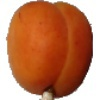

In [4]:
import boto3
import PIL.Image

s3_bucket_name = "cloudfruits360"
image_key = "Apricot/0_100.jpg"

s3 = boto3.client('s3')
image = s3.get_object(Bucket=s3_bucket_name, Key=image_key)
PIL.Image.open(image['Body'])

## Utiliser PySpark

In [8]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

#sc = SparkContext()
sc = SparkContext.getOrCreate()
sc.setLogLevel("ERROR")
spark = SparkSession(sparkContext=sc)
nums = spark.sparkContext.parallelize([1,2,3,4])
print(nums.map(lambda x: x*x).collect())

[1, 4, 9, 16]


 ## Utiliser PySpark avec accès à S3

In [9]:
s3_bucket_name = 'cloudfruits360'
s3_bucket_name_database = 'Training/'
df = spark.read.format('Image').load(f's3a://{s3_bucket_name}/{s3_bucket_name_database}/*.jpg')
df.show()

+--------------------+
|               image|
+--------------------+
|{s3a://cloudfruit...|
|{s3a://cloudfruit...|
|{s3a://cloudfruit...|
|{s3a://cloudfruit...|
|{s3a://cloudfruit...|
|{s3a://cloudfruit...|
|{s3a://cloudfruit...|
|{s3a://cloudfruit...|
|{s3a://cloudfruit...|
|{s3a://cloudfruit...|
|{s3a://cloudfruit...|
|{s3a://cloudfruit...|
|{s3a://cloudfruit...|
|{s3a://cloudfruit...|
|{s3a://cloudfruit...|
|{s3a://cloudfruit...|
|{s3a://cloudfruit...|
|{s3a://cloudfruit...|
|{s3a://cloudfruit...|
|{s3a://cloudfruit...|
+--------------------+
only showing top 20 rows



## Définition des PATH pour charger les images et enregistrer les résultats


In [10]:
s3_bucket_name = 'cloudfruits360'
s3_input_images_process_bucket = 'Training'
s3_output_images_features_processed = 'results_images_features_processed'
s3_output_images_processed = 'images_processed'
s3_output_features_classify = 'features_classify'
s3_output_features_parquet = "P8_cloud_fruits_features.parquet"

## Traitement des données
### A.Chargement des données

In [11]:
# Connect to S3 storage
s3_bucket = boto3.resource('s3').Bucket(s3_bucket_name)

print("... list images dans AWS S3 bucket input_images_to_process")

# list images from Fruits 360 dataset
image_keys = [image.key for image in s3_bucket.objects.filter(Prefix=s3_input_images_process_bucket) if '.jpg' in image.key]
print(f"Contains {len(image_keys)} images.")
print(image_keys)  

... list images dans AWS S3 bucket input_images_to_process
Contains 54 images.
['Training/Apple_Golden_1_0_100.jpg', 'Training/Apple_Golden_1_10_100.jpg', 'Training/Apple_Golden_1_1_100.jpg', 'Training/Apple_Golden_1_2_100.jpg', 'Training/Apple_Golden_1_3_100.jpg', 'Training/Apple_Golden_1_4_100.jpg', 'Training/Apple_Golden_1_5_100.jpg', 'Training/Apple_Golden_1_6_100.jpg', 'Training/Apple_Golden_1_7_100.jpg', 'Training/Apple_Golden_1_8_100.jpg', 'Training/Apple_Golden_1_9_100.jpg', 'Training/Apricot_0_100.jpg', 'Training/Apricot_10_100.jpg', 'Training/Apricot_12_100.jpg', 'Training/Apricot_13_100.jpg', 'Training/Apricot_14_100.jpg', 'Training/Apricot_15_100.jpg', 'Training/Apricot_16_100.jpg', 'Training/Apricot_17_100.jpg', 'Training/Apricot_1_100.jpg', 'Training/Apricot_2_100.jpg', 'Training/Blueberry_0_100.jpg', 'Training/Blueberry_10_100.jpg', 'Training/Blueberry_1_100.jpg', 'Training/Blueberry_2_100.jpg', 'Training/Blueberry_3_100.jpg', 'Training/Blueberry_4_100.jpg', 'Training/Bl

## Création de la SparkSession

Renvoie : (SparkSession) ma session Spark

In [12]:
def start_spark() -> SparkSession:
    spark = SparkSession.builder \
    .master("local") \
    .appName("cloudfruit") \
    .config("spark.sql.parquet.writeLegacyFormat", 'true')\
    .getOrCreate()
    return spark

In [13]:
#Affichage des informations de Spark en cours d'execution
spark


Charger une image à partir du stockage AWS S3.
Arguments :
image_key (str) : clé d'image dans le compartiment AWS S3
bucket_name (str) : nom du compartiment S3
Renvoie : (PIL.Image.Image) données d'image RVB

In [14]:
def load_image(image_key: str, bucket_name: str) -> PIL.Image.Image:
    bucket = boto3.resource('s3').Bucket(bucket_name)
    buffer = BytesIO()
    bucket.Object(image_key).download_fileobj(buffer)
    return PIL.Image.open(buffer)

Encode une image dans un vecteur de longueur fixe de valeurs flottantes à l'aide d'un encodeur DNN pré-entraîné.
Arguments :
img (Row): image_key (str): clé d'image dans le compartiment AWS S3
Renvoie : (Row) l'encodage de l'image, représenté par une Row avec des champs :
origin (str) : chemin d'origine de l'image (c'est-à-dire la clé de l'image dans le compartiment S3)
label (str): le label de l'image
x0 (float): première fonctionnalité d'encodage d'image
(...)
x_(n-1) (float) : dernière fonctionnalité d'encodage d'image

In [15]:
def process_image(image_key: str) -> Row:
    image_label = image_key.split('/')[-2]
    image_array = load_image(image_key=image_key, bucket_name=s3_bucket_name)
    image_encoding = broadcastEncoder.value.encode(image_array)
    image_encoding = {f'x{i}': value for i, value in enumerate(image_encoding)}
    return Row(origin=image_key, label=image_label, **image_encoding)

On va charger l'encodeur d'image, encoder les images et écrire la sortie dans le fichier du dossier de sortie du compartiment AWS S3, ensuite on va écrire le résultat sous forme de fichier parquet dans le compartiment AWS S3. enregistrer en tant que fichier csv et enregistrer en tant que fichier parquet

In [16]:
if len(image_keys) > 0:
    
    spark = start_spark()
    s3_client = boto3.client('s3')
    
    currentDate = datetime.datetime.today()
    
    print("**** charger l'encodeur d'image ****")
    broadcastEncoder = spark.sparkContext.broadcast(Encoder())
      
    print("**** encoder les images et écrire la sortie dans le fichier du dossier de sortie du compartiment AWS S3 ****")
    output = spark.sparkContext.parallelize(image_keys).map(process_image).toDF()

    # La méthode coalesce réduit le nombre de partitions dans un DataFrame
    # coalesce(1) consolide les données dans une seule partition
    # enregistrer en tant que fichier csv
    #output.coalesce(1).write.csv(f's3a://{s3_bucket_name}/{s3_output_images_features_processed}/{currentDate.strftime("%Y%m%d-%H%M%S")}/results.csv') 
    
    # Écrire le résultat dans le dossier de sortie du compartiment AWS s3
    print(f"**** Écrire le résultat sous forme de fichier parquet dans le compartiment AWS S3 {s3_output_images_features_processed}****")
    # enregistrer en tant que fichier parquet
    output.coalesce(1).write.parquet(f's3a://{s3_bucket_name}/{s3_output_images_features_processed}/{currentDate.strftime("%Y%m%d-%H%M%S")}/{s3_output_features_classify}') 

    # lister le fichier de parquet du dossier de sortie
    s3_prefix = s3_output_images_features_processed + "/" + currentDate.strftime("%Y%m%d-%H%M%S") +"/" + s3_output_features_classify
    parquet_files = [parquet_file for parquet_file in s3_bucket.objects.filter(Prefix=s3_prefix) if '.parquet' in parquet_file.key]    
    print(f"**** Renommera le fichier {parquet_files}****")

    if len(parquet_files) == 1:
        parquet_file = parquet_files[0]
        filename = parquet_file.key.split('/')[-1]
        folder = parquet_file.key.split('/')[-2]        
        try:
            output_key = f'{s3_output_images_features_processed}/{currentDate.strftime("%Y%m%d-%H%M%S")}/{folder}/{s3_output_features_parquet}'
            print(f"**** Renommera le fichier {filename} de {output_key}")
            copy_source = {'Bucket': s3_bucket_name, 'Key': parquet_file.key}
            s3_client.copy_object(Bucket = s3_bucket_name, CopySource = copy_source, Key = output_key)
            s3_client.delete_object(Bucket = s3_bucket_name, Key = parquet_file.key)    
            print(f"**** Fichier {filename} renommé avec succès en {output_key}****")
        except Exception as e:
            print(f"****{filename} pas renommé correctement. L'erreur relevée est: ****", e)
        
    spark.sparkContext.stop()

else:
    print("****pas de fichier à traiter, fin de script****")

**** charger l'encodeur d'image ****
**** encoder les images et écrire la sortie dans le fichier du dossier de sortie du compartiment AWS S3 ****


**** Écrire le résultat sous forme de fichier parquet dans le compartiment AWS S3 results_images_features_processed****


**** Renommera le fichier [s3.ObjectSummary(bucket_name='cloudfruits360', key='results_images_features_processed/20221127-131130/features_classify/part-00000-6a59c483-4fce-49e7-920c-462f204f944b-c000.snappy.parquet')]****
**** Renommera le fichier part-00000-6a59c483-4fce-49e7-920c-462f204f944b-c000.snappy.parquet de results_images_features_processed/20221127-131130/features_classify/P8_cloud_fruits_features.parquet
**** Fichier part-00000-6a59c483-4fce-49e7-920c-462f204f944b-c000.snappy.parquet renommé avec succès en results_images_features_processed/20221127-131130/features_classify/P8_cloud_fruits_features.parquet****


## Déplacer les données vers le dossier traité


In [17]:
if len(image_keys) > 0:

    # Connect to S3 storage
    s3_bucket = boto3.resource('s3').Bucket(s3_bucket_name)
    s3_client = boto3.client('s3')

    # Empty S3 storage
    s3_bucket_images = [image for image in s3_bucket.objects.filter(Prefix=s3_input_images_process_bucket) if '.jpg' in image.key]
    print(f"*** va bouger {len(s3_bucket_images)} fichiers de l'ensemble de données Fruits 360 dans le compartiment AWS S3, à partir de{s3_input_images_process_bucket} to {s3_output_images_features_processed}/{s3_output_images_processed}")
    for s3_bucket_image in s3_bucket_images:
        filename = s3_bucket_image.key.split('/')[-1]
        try:
            output_key = f'{s3_output_images_features_processed}/{currentDate.strftime("%Y%m%d-%H%M%S")}/{s3_output_images_processed}/{filename}'
            print(f'Déplacera le fichier de {s3_bucket_image.key} à {output_key}')

            copy_source = {'Bucket': s3_bucket_name, 'Key': s3_bucket_image.key}
            s3_client.copy_object(Bucket = s3_bucket_name, CopySource = copy_source, Key = output_key)
            s3_client.delete_object(Bucket = s3_bucket_name, Key = s3_bucket_image.key)    
            print(f'Fichier {filename} renommé avec succès en {output_key}')
        except:
            print(f"Exception levée. {filename} pas déplacé correctement")
            
else:
    print("***pas de fichier à traiter, fin de script***")
    

*** va bouger 54 fichiers de l'ensemble de données Fruits 360 dans le compartiment AWS S3, à partir deTraining to results_images_features_processed/images_processed
Déplacera le fichier de Training/Apple_Golden_1_0_100.jpg à results_images_features_processed/20221127-131130/images_processed/Apple_Golden_1_0_100.jpg
Fichier Apple_Golden_1_0_100.jpg renommé avec succès en results_images_features_processed/20221127-131130/images_processed/Apple_Golden_1_0_100.jpg
Déplacera le fichier de Training/Apple_Golden_1_10_100.jpg à results_images_features_processed/20221127-131130/images_processed/Apple_Golden_1_10_100.jpg
Fichier Apple_Golden_1_10_100.jpg renommé avec succès en results_images_features_processed/20221127-131130/images_processed/Apple_Golden_1_10_100.jpg
Déplacera le fichier de Training/Apple_Golden_1_1_100.jpg à results_images_features_processed/20221127-131130/images_processed/Apple_Golden_1_1_100.jpg
Fichier Apple_Golden_1_1_100.jpg renommé avec succès en results_images_features